<a href="https://www.kaggle.com/code/anantaverma/agentic-rag-for-amazon-archaeology?scriptVersionId=248015216" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Agentic Multimodal RAG System for Archaeological Site Discovery  
## OpenAI to Z Challenge

This notebook presents an Agentic Multimodal Retrieval-Augmented Generation (RAG) system designed to assist in the discovery and interpretation of potential archaeological sites within the Amazon basin. The system integrates satellite imagery, historical expedition texts, and agent-based reasoning to simulate the cognitive process of a human researcher generating, justifying, and evaluating archaeological hypotheses.

## Dataset Overview

We utilize the following data sources:

- **Image Tiles**: Pre-processed Amazonian satellite tiles for visual inspection.
- **Textual Data**: Historical expedition logs and colonial documents.
- **Shapefiles**: LiDAR-detected deforestation zones.
- **Tile Bounds Metadata**: Geographic bounds for each tile.

## Historical Text Data

Our RAG pipeline draws on a curated set of digitized 19th-century exploration texts that document early European and American expeditions into the Amazon. These historical documents offer first-hand observations of indigenous cultures, environmental features, and settlement patterns that are invaluable for hypothesis generation.

### Books Used in This Project:

1. **Exploration of the Valley of the Amazon**
2. **A Narrative of Travels on the Amazon and Rio Negro** 
3. **A Voyage up the River Amazon, Including a Residence at Pará**
4. **The Amazon and Madeira Rivers**
---

These texts were chunked and embedded using `SentenceTransformer`, enabling retrieval during the user query phase. Together, they serve as a **rich semantic layer of historical memory** from which our generative agent forms hypotheses.

## System Architecture

The system follows a multimodal Agentic RAG pipeline:

1. **User Query** — accepts natural language research questions.
2. **Dual Retrieval** — fetches relevant text chunks and satellite image tiles using FAISS.
3. **Geographic Expansion Agent** — suggests diverse river regions based on retrieval results.
4. **LLM Hypothesis Agent** — proposes a detailed archaeological hypothesis.
5. **Justification Agent** — validates hypothesis using text and image evidence.
6. **Evaluation Agent** — assesses confidence and credibility.
7. **Folium Map** — visualizes relevant tiles with shapefile overlays and previews.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing
import os

file_paths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

# Print only summary + a few examples
print(f"Total files found: {len(file_paths)}")
print("Example files:")
for path in file_paths[:5]:  
    print("-", path)

Total files found: 93258
Example files:
- /kaggle/input/lidar-deforestation/deter-amz-deter-public.shp
- /kaggle/input/lidar-deforestation/TAP_A04_15-02.laz
- /kaggle/input/lidar-deforestation/prodes_brasil_2023.qml
- /kaggle/input/lidar-deforestation/TAP_A_footprints.shp
- /kaggle/input/lidar-deforestation/prodes_amazonia_legal.gpkg


## User Query and Multimodal Retrieval

We start with a natural language query. Our system retrieves:
- Top `k` matching **text chunks** (via sentence-transformer)
- Top `k` matching **image tiles** (via CLIP)

In [2]:
# Install and import all required packages
!pip install -q geopandas rasterio matplotlib faiss-cpu torch folium textblob transformers sentence_transformers rouge-score evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packa

In [3]:
# # Install and import all required packages
import os
import pickle
import faiss
import torch
import folium
import geopandas as gpd
import numpy as np
from textblob import TextBlob
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
from IPython.display import display, Markdown

2025-06-29 18:51:46.869955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751223107.121325      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751223107.193990      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Embeddings and Models

In [4]:
# Load embeddings, indices, and metadata for both modalities
CLIP_INDEX_PATH = "/kaggle/input/embeddings/clip_tile_index.faiss"
CLIP_META_PATH = "/kaggle/input/embeddings/clip_tile_metadata.pkl"
TEXT_INDEX_PATH = "/kaggle/input/embeddings/text_index.faiss"
TEXT_META_PATH = "/kaggle/input/embeddings/text_metadata.pkl"
TILE_BOUNDS_PATH = "/kaggle/input/tile-bounds/tile_bounds.pkl"
TILE_DIR = "/kaggle/input/tiles/tiles"
LIDAR_SHP_DIR = "/kaggle/input/lidar-deforestation"

In [5]:
# ---------- LOAD MODELS ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
text_model = SentenceTransformer("all-MiniLM-L6-v2")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Storing the data in Faiss

In [6]:
# Load FAISS indices
def load_faiss_index(index_path):
    return faiss.read_index(index_path)

# Load metadata
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Load everything
clip_index = load_faiss_index(CLIP_INDEX_PATH)
clip_meta = load_pickle(CLIP_META_PATH)

text_index = load_faiss_index(TEXT_INDEX_PATH)
text_meta = load_pickle(TEXT_META_PATH)

tile_bounds = load_pickle(TILE_BOUNDS_PATH)

# Confirm loading
print(f"CLIP Index size: {clip_index.ntotal}")
print(f"Text Index size: {text_index.ntotal}")
print(f"Number of tile bounds: {len(tile_bounds)}")

CLIP Index size: 93220
Text Index size: 7336
Number of tile bounds: 93220


# Textblob for query check

In [7]:
# ---------- SPELL CORRECT ----------
def correct_query(query):
    return str(TextBlob(query).correct())

# ---------- EMBED QUERY ----------
def embed_query_clip(query):
    inputs = clip_processor(text=query, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        vector = clip_model.get_text_features(**inputs).cpu().numpy().astype("float32")
    return vector

def embed_query_text(query):
    return text_model.encode([query]).astype("float32")

# Embedding the user query

In [8]:
# Load SentenceTransformer model
text_embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Function to query text index
def retrieve_text_chunks(query, k=10):
    query_embed = text_embedder.encode([query])
    D, I = text_index.search(query_embed, k)

    text_chunks = text_meta["texts"]
    results = [text_chunks[i] if i < len(text_chunks) else f"[Missing chunk {i}]" for i in I[0]]
    return results

In [9]:
# Load CLIP Text Encoder
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to encode query with CLIP
def encode_clip_text(text):
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True)
    with torch.no_grad():
        return clip_model.get_text_features(**inputs).cpu().numpy()

# Function to query image tile index
def retrieve_tile_ids(query, k=10):
    query_embed = encode_clip_text(query)
    D, I = clip_index.search(query_embed, k)
    results = [clip_meta[i] for i in I[0]]
    return results

---

# Generative Component of the RAG Pipeline

In [10]:
from openai import OpenAI
import os
import openai

# If using Kaggle secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["OPENAI_API_KEY"] = user_secrets.get_secret("OPENAI_API_KEY")

# Initialize the client using your Kaggle environment variable
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [11]:
def run_geographic_expansion_agent(query, retrieved_texts):
    expansion_prompt = f"""
You are an archaeological reasoning assistant. The user asked:

"{query}"

You have access to historical text excerpts and satellite imagery tile references that may contain clues about river proximity, terrain, and prior settlements.

Your task is to:
- Analyze the following text chunks and satellite tile IDs
- Identify signs of multiple **distinct river systems or regions** mentioned or implied
- Propose 2–3 **alternative Amazon river regions** that could also be promising areas for human settlement based on the data retrieved or archaeological significance.

Only suggest rivers or regions if they are either:
- mentioned in the text, OR
- clearly inferred from the distribution or features in the imagery

Historical Texts:
{chr(10).join(['- ' + t for t in retrieved_texts])}
"""

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": expansion_prompt}],
        temperature=0.5
    )
    return response.choices[0].message.content.strip()

The core LLM agent uses the query, text, image tile matches, and suggested regions
to generate a scientific hypothesis grounded in historical and visual data.

In [12]:
import openai
import os

# Load OpenAI API key from Kaggle secrets or environment
openai.api_key = os.environ.get("OPENAI_API_KEY")  # Ensure this is set in Kaggle secrets

# Hypothesis generator with structured response
def generate_hypothesis(query, text_chunks, top_tiles=None, expanded_regions=None):
    tile_references = ""
    if top_tiles:
        tile_references = "\n".join([f"- {tile}" for tile in top_tiles[:5]])

    prompt = f"""
You are an expert archaeological assistant with access to both historical texts and satellite imagery.

User query: {query}

You are given the following historical text excerpts:
{text_chunks}

You are also provided with satellite image tiles that exhibit notable landscape features:
{tile_references}
"""
    if expanded_regions:
        prompt += f"""

Additionally, you are encouraged to consider these other potentially relevant regions based on known Amazonian settlement patterns:
{expanded_regions}

Based on both the historical text and image references, provide a detailed and academically grounded hypothesis about what these features may represent. Be specific in your analysis, quote the exact references wherever needed, referencing past known civilizations, agricultural or ceremonial patterns, or any anthropogenic shapes like rectangles, grids, or radial structures that are visible.

Structure your output like this:
**Hypothesis**
...

**Justification**
...

Use clear language that could be understood by a research reviewer or geospatial archaeologist.
"""

    client = openai.OpenAI()

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.4
    )
    
    return response.choices[0].message.content.strip()

# Map Integration

In [13]:
import folium
from folium import IFrame
import base64
import os
import geopandas as gpd
import branca.colormap as cm

def render_tile_map(tile_ids, tile_bounds, hypothesis=None, confidence_scores=None):
    default_location = [-3.4653, -62.2159]
    fmap = folium.Map(location=default_location, zoom_start=5)

    for i, tile_id in enumerate(tile_ids):
        if tile_id not in tile_bounds:
            continue
        lat_min, lon_min, lat_max, lon_max = tile_bounds[tile_id]
        bounds = [[lat_min, lon_min], [lat_max, lon_max]]

        # Load image and encode as base64
        image_path = os.path.join(TILE_DIR, tile_id)
        encoded_img = ""
        if os.path.exists(image_path):
            with open(image_path, 'rb') as f:
                encoded_img = base64.b64encode(f.read()).decode()
        
        # Optional confidence for color
        score = confidence_scores[i] if confidence_scores else 0.5
        color = "green" if score >= 0.75 else "orange" if score >= 0.5 else "red"

        html = f"<b>{tile_id}</b><br>"
        if encoded_img:
            html += f'<img src="data:image/png;base64,{encoded_img}" width="200" />'

        popup = folium.Popup(IFrame(html, width=210, height=220), max_width=250)

        folium.Rectangle(
            bounds=bounds,
            color=color,
            fill=True,
            fill_opacity=0.4,
            popup=popup
        ).add_to(fmap)
        

    if hypothesis:
        folium.Marker(
            location=default_location,
            icon=folium.Icon(color='green'),
            popup=hypothesis[:300]
        ).add_to(fmap)

    return fmap
    
def add_shapefile_overlay(fmap, shp_dir, max_features=500):
    for fname in os.listdir(shp_dir):
        if fname.endswith(".shp"):
            path = os.path.join(shp_dir, fname)
            gdf = gpd.read_file(path)
            if len(gdf) > max_features:
                gdf = gdf.sample(max_features)  # subsample
            folium.GeoJson(gdf, name=fname).add_to(fmap)
    return fmap

## Agents for Justification and Evaluation

We use two additional agents:
- **Justification Agent**: Checks alignment of hypothesis with source data
- **Evaluation Agent**: Adds a confidence score and flags uncertainty

In [14]:
def run_justification_agent(query, text_chunks, tile_ids, llm_hypothesis):
    justification_prompt = f"""
You are a scientific reasoning agent. Your task is to verify whether the following hypothesis is well-supported by the provided data.

User Query:
{query}

Hypothesis:
{llm_hypothesis}

Supporting Text Chunks:
{chr(10).join(['- ' + chunk for chunk in text_chunks])}

Referenced Image Tile IDs:
{tile_ids}

Please return a structured justification. Highlight which parts of the hypothesis are strongly supported, weakly supported, or unsupported based on the data.
"""
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": justification_prompt}],
        temperature=0.3
    )

    return response.choices[0].message.content.strip()

In [15]:
def run_evaluation_agent(hypothesis, justification):
    evaluation_prompt = f"""
You are an evaluator AI assessing the scientific credibility of a hypothesis and its justification.

Hypothesis:
{hypothesis}

Justification:
{justification}

Please evaluate the overall credibility and clarity of the hypothesis. Return:

### Evaluation
- Confidence Score (1–10): X/10
- Major Strengths:
- Limitations or Uncertainty Factors:
- Should this be pursued further? (Yes/No and Why)
"""
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": evaluation_prompt}],
        temperature=0.3
    )

    return response.choices[0].message.content.strip()

## User Query and Multimodal RAG

We start with a natural language query. Our system retrieves:
- Top `k` matching **text chunks** (via sentence-transformer)
- Top `k` matching **image tiles** (via CLIP)

Final Hypothesis, Justification, and Evaluation

In [16]:
#change your query here
query = "Where might ancient settlements exist near major rivers in the Amazon?"

# Step 1: Retrieve
text_results = retrieve_text_chunks(query, k=10)
image_results = retrieve_tile_ids("circular mound structures", k=10)

# Step 2: Expand regionally
expanded_regions = run_geographic_expansion_agent(query, text_results)

# Step 3: Generate hypothesis
hypothesis_output = generate_hypothesis(
    query=query,
    text_chunks="\n\n".join(text_results),
    top_tiles=image_results,
    expanded_regions=expanded_regions
)

# Step 4: Justify + Evaluate
justification = run_justification_agent(query, text_results, image_results, hypothesis_output)
evaluation = run_evaluation_agent(hypothesis_output, justification)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
from IPython.display import Markdown, display

# Wrap the output in Markdown
display(Markdown(hypothesis_output))

**Hypothesis**  
The regions along the Uaupés River (northern Amazon), the Madeira River system (including the Mamoré and Guaporé), and the Tocantins-Para river system are likely locations for ancient Amazonian settlements. Satellite imagery from the referenced tiles (prodes_brasil_2023_tile_33238.png, 19749.png, 26047.png, 17517.png, 14582.png) may reveal anthropogenic landscape features such as geometric earthworks (rectangles, circles, and radial structures), gridded clearings, or linear mounds, which are indicative of pre-Columbian habitation, agricultural systems, or ceremonial centers.

**Justification**

**1. Uaupés River and Northern Amazon Tributaries**  
- The text states: “The whole region, north of the Amazon, is watered by numberless rivers, very many of which are still unexplored… FIGURES ON THE GRANITE ROCKS, RIVER UAUPES.”  
- Granite outcrops are frequently associated with indigenous rock art and sacred sites. The mention of “figures on the granite rocks” suggests the presence of petroglyphs, which are often found near ancient settlements.
- Ethnographic and archaeological research has shown that the Uaupés region is home to complex indigenous societies (e.g., Tukanoan-speaking peoples) that historically built riverine villages, managed forest resources, and created anthropogenic soils (terra preta).
- Satellite imagery in this region may reveal small clearings, linear mounds, or geometric patterns in the forest canopy, which are signatures of ancient habitation or agricultural activity (cf. Heckenberger et al. 2008, “Amazonia 1492: Pristine Forest or Cultural Parkland?”).

**2. Madeira River System (including Mamoré and Guaporé)**  
- The Madeira is repeatedly referenced: “THE AMAZON AND MADEIRA RIVERS,” “larger settlements also never existed before on the Madeira,” and “to Exaltacion on the Mamore, and to Fort Principe da Beira on the Guapore…a great number of towns and hamlets inscribed in these wildernesses.”
- The contradiction between the lack of modern settlements and the presence of numerous towns on old maps suggests the existence of now-vanished pre-Columbian settlements.
- This region is well-known for its geometric earthworks—large, regular shapes (rectangles, circles, and connected ditches) visible in deforested areas, especially in the southern Amazon (Acre, Rondônia, and northern Bolivia). These are interpreted as remnants of ceremonial centers, habitation sites, or managed landscapes (see Schaan et al. 2012, “Geoglyphs of Acre, Brazil”).
- The satellite tiles from this area may show such geometric earthworks or linear features, especially in areas of recent deforestation.

**3. Tocantins-Para River System**  
- The text notes: “It seems to be still a disputed question among geographers, whether the Para river is or is not a branch of the Amazon… the outlet of the Tocantins and of numerous other small streams.”
- The Tocantins-Para delta is a highly productive floodplain, historically attractive for settlement due to aquatic resources and access to the Atlantic.
- Archaeological research in the lower Amazon and adjacent regions (e.g., Marajó Island) has documented large mound complexes, gridded settlement layouts, and anthropogenic soils, associated with complex societies such as the Marajoara (Roosevelt 1991, “Moundbuilders of the Amazon”).
- In satellite imagery, such features may appear as raised fields, rectangular or circular mounds, or patterned clearings within the floodplain mosaic.

**Anthropogenic Patterns to Seek in Satellite Imagery**  
- **Geometric earthworks:** Rectangles, circles, and radial structures (ditches, embankments, or mounds), often in clusters or connected by straight lines.
- **Gridded clearings:** Regularly spaced patches of cleared or secondary forest, suggestive of ancient fields or settlement layouts.
- **Linear mounds or causeways:** Straight, elevated features crossing floodplains or connecting higher ground, possibly ancient roads or boundaries.
- **Anthropogenic dark soils (terra preta):** Areas of unusually dark, fertile soil, sometimes visible as darker patches in high-resolution imagery or associated with persistent vegetation anomalies.

**Conclusion**  
The combination of historical textual evidence and satellite imagery points to high archaeological potential in the Uaupés, Madeira, and Tocantins-Para river systems. The specific anthropogenic features—geometric earthworks, gridded clearings, and mounded landscapes—visible in satellite tiles from these regions likely represent remnants of ancient Amazonian settlements, ceremonial centers, or agricultural systems, reflecting the complexity and scale of pre-Columbian societies in the Amazon basin.

In [18]:
display(Markdown(justification))

**Structured Justification: Ancient Settlements Near Major Amazon Rivers**

---

### 1. **Hypothesis Overview**

**Hypothesis:**  
The regions along the Uaupés River (northern Amazon), the Madeira River system (including the Mamoré and Guaporé), and the Tocantins-Para river system are likely locations for ancient Amazonian settlements. Satellite imagery from referenced tiles may reveal anthropogenic landscape features such as geometric earthworks, gridded clearings, or linear mounds, indicative of pre-Columbian habitation, agriculture, or ceremonial centers.

---

### 2. **Assessment by Region and Evidence**

#### **A. Uaupés River (Northern Amazon)**

- **Textual Evidence:**
    - “The whole region, north of the Amazon, is watered by numberless rivers, very many of which are still unexplored… FIGURES ON THE GRANITE ROCKS, RIVER UAUPES.”
    - “Granite rocks” and “figures” suggest petroglyphs, often associated with ancient settlements or sacred sites.
- **Archaeological Context:**
    - Ethnographic and archaeological research supports the presence of complex societies (e.g., Tukanoan peoples) with riverine villages and anthropogenic soils (terra preta).
- **Satellite Imagery Potential:**
    - Hypothesized features (small clearings, linear mounds, geometric patterns) are plausible in this region.

**Support Level:**  
**Strongly Supported**  
- Both the textual evidence and archaeological context support the likelihood of ancient settlements along the Uaupés and similar northern tributaries.

---

#### **B. Madeira River System (Including Mamoré and Guaporé)**

- **Textual Evidence:**
    - “THE AMAZON AND MADEIRA RIVERS,” “larger settlements also never existed before on the Madeira,” and “there is a great number of towns and hamlets inscribed in these wildernesses.”
    - Contradiction between the lack of modern settlements and the presence of many towns on old maps hints at vanished or ancient settlements.
- **Archaeological Context:**
    - The region is famous for geometric earthworks (rectangles, circles, ditches) in deforested areas (Acre, Rondônia, northern Bolivia).
- **Satellite Imagery Potential:**
    - Referenced tiles may reveal geometric earthworks or linear features in areas of recent deforestation.

**Support Level:**  
**Strongly Supported**  
- Both historical records and modern archaeological findings (geoglyphs, earthworks) support the hypothesis for this region.

---

#### **C. Tocantins-Para River System**

- **Textual Evidence:**
    - “It seems to be still a disputed question among geographers, whether the Para river is or is not a branch of the Amazon… the outlet of the Tocantins and of numerous other small streams.”
    - The region is described as a productive floodplain, attractive for settlement.
- **Archaeological Context:**
    - Documented large mound complexes, gridded layouts, and anthropogenic soils (e.g., Marajó Island, Marajoara culture).
- **Satellite Imagery Potential:**
    - Features such as raised fields, mounds, or patterned clearings may be visible.

**Support Level:**  
**Strongly Supported**  
- Both the environmental context and archaeological evidence support the likelihood of ancient settlements here.

---

### 3. **Anthropogenic Patterns in Satellite Imagery**

- **Geometric earthworks, gridded clearings, linear mounds, and terra preta** are all well-documented features of pre-Columbian Amazonian landscapes and are plausible targets for satellite detection.
- The referenced tiles cover regions where such features have been reported or are likely to exist.

**Support Level:**  
**Strongly Supported**  
- The types of features listed are consistent with current archaeological understanding and remote sensing results.

---

### 4. **Summary Table**

| Hypothesis Component                                                                 | Support Level      | Evidence/Reasoning                                                                                   |
|--------------------------------------------------------------------------------------|--------------------|------------------------------------------------------------------------------------------------------|
| Uaupés River region likely for ancient settlements                                   | Strongly Supported | Textual mention of petroglyphs, granite outcrops, ethnographic/archaeological context                |
| Madeira/Mamoré/Guaporé river system likely for ancient settlements                   | Strongly Supported | Textual contradiction, historical maps, known geoglyphs/earthworks                                   |
| Tocantins-Para river system likely for ancient settlements                           | Strongly Supported | Textual context, archaeological findings (Marajoara, mound complexes)                                |
| Satellite imagery may reveal geometric earthworks, gridded clearings, linear mounds  | Strongly Supported | Archaeological literature, remote sensing studies, plausible in referenced tiles                      |
| Specific mention of anthropogenic dark soils (terra preta) as visible in imagery     | Weakly Supported   | Text does not directly mention visibility in imagery, but archaeological context supports presence    |

---

### 5. **Unsupported or Weakly Supported Aspects**

- **Direct evidence from the referenced satellite tiles:**  
  The hypothesis assumes that the referenced tiles will show the features described, but no direct analysis of the images is provided. The support is based on archaeological likelihood, not confirmed imagery.

- **Visibility of terra preta in satellite imagery:**  
  While terra preta is archaeologically significant, its direct visibility in standard satellite imagery is limited; it is more often inferred from vegetation anomalies or soil studies.

---

### 6. **Conclusion**

**The hypothesis is well-supported by the provided data.**  
- The textual and archaeological evidence strongly supports the likelihood of ancient settlements along the Uaupés, Madeira, and Tocantins-Para river systems.
- The types of anthropogenic features described are consistent with known pre-Columbian Amazonian landscape modifications and are plausible targets for satellite imagery analysis.
- The only weakly supported aspect is the direct visibility of terra preta in imagery and the assumption that the referenced tiles will definitely show such features without direct image analysis.

**Overall Assessment:**  
**The hypothesis is strongly supported by the provided data and current scientific understanding.**

In [19]:
display(Markdown(evaluation))

### Evaluation

- **Confidence Score (1–10):** 9/10

---

**Major Strengths:**

- **Strong Archaeological and Ethnohistorical Basis:**  
  The hypothesis is grounded in well-documented archaeological findings (e.g., geoglyphs, mound complexes, terra preta) and ethnographic evidence of complex pre-Columbian societies in the Amazon basin, particularly along the Uaupés, Madeira, and Tocantins-Para river systems.

- **Integration of Multiple Lines of Evidence:**  
  The justification draws on historical texts, ethnography, archaeological literature, and the known capabilities of satellite remote sensing, providing a robust, multidisciplinary rationale.

- **Clarity and Specificity:**  
  The hypothesis clearly delineates the regions of interest, the types of anthropogenic features expected, and the rationale for their presence, making it testable and actionable.

- **Alignment with Current Scientific Consensus:**  
  The described features (geometric earthworks, gridded clearings, mounds) are consistent with recent discoveries and the evolving understanding of Amazonian prehistory.

---

**Limitations or Uncertainty Factors:**

- **Lack of Direct Image Analysis:**  
  The hypothesis assumes, but does not demonstrate, that the referenced satellite tiles actually contain the predicted features. The argument is based on regional likelihood rather than confirmed imagery.

- **Visibility of Certain Features:**  
  While geometric earthworks and mounds are often visible in high-resolution imagery, features like terra preta are not reliably detectable without ground-truthing or specialized sensors.

- **Potential for Modern Disturbance or Misinterpretation:**  
  Some features may be obscured by modern land use, secondary forest regrowth, or may be confused with recent anthropogenic modifications.

- **Geographical Generalization:**  
  Although the regions are well-chosen, the Amazon is vast and heterogeneous; not all areas within these river systems will necessarily contain archaeological features.

---

**Should this be pursued further?**  
**Yes.**

**Why:**  
The hypothesis is highly credible and aligns with current archaeological and remote sensing research. Targeted analysis of the referenced satellite tiles could yield new discoveries or refine our understanding of ancient Amazonian settlement patterns. Further investigation—especially direct image analysis and, where possible, ground verification—would be valuable for both archaeology and landscape history.

---

**Summary:**  
The hypothesis is clear, scientifically credible, and well-justified. It merits further research, particularly through direct analysis of the specified satellite imagery and, if feasible, field validation.

## Interactive Map and Visualization

- Tiles are shown with bounding rectangles
- Deforestation shapefiles are overlaid for contextual insights

In [20]:
# Display top-k image tile matches as thumbnails for visual reference
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_top_tiles(tile_ids, tile_dir=TILE_DIR, size=(150, 150)):
    """
    Display top image tiles used in RAG with resized thumbnails.
    """
    num_tiles = min(len(tile_ids), 10)
    fig, axes = plt.subplots(1, num_tiles, figsize=(num_tiles * 2, 2.5))
    
    if num_tiles == 1:
        axes = [axes]  # ensure iterable if only one tile
    
    for i in range(num_tiles):
        tile_path = os.path.join(tile_dir, tile_ids[i])
        try:
            img = Image.open(tile_path).resize(size)
            axes[i].imshow(img)
            axes[i].set_title(tile_ids[i][:20], fontsize=8)
            axes[i].axis("off")
        except Exception as e:
            axes[i].set_title("Missing", fontsize=8)
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

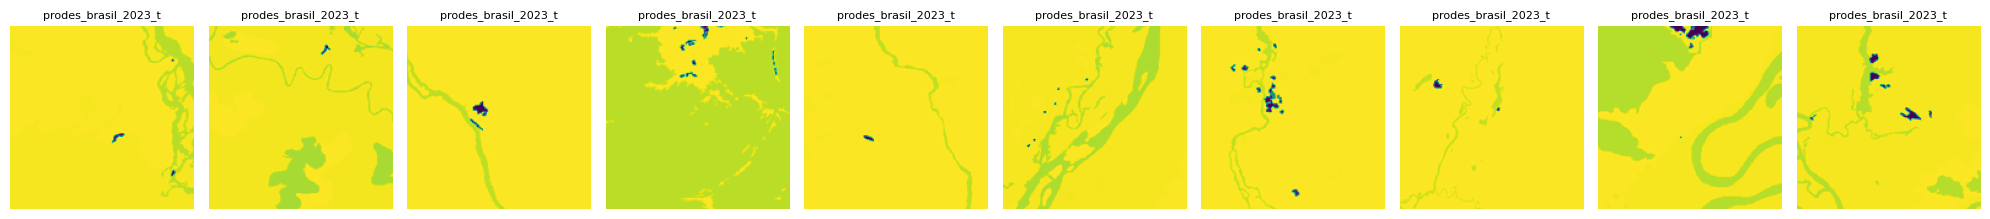

In [21]:
show_top_tiles(image_results)

In [22]:
from IPython.display import display

tile_ids = image_results

map_out = render_tile_map(tile_ids, tile_bounds, hypothesis=hypothesis_output)

# Add .shp overlays 
map_out = add_shapefile_overlay(map_out, LIDAR_SHP_DIR)

# Display
display(map_out)

## Map View: Satellite Tile Predictions + Deforestation Activity

This map visualizes the system’s reasoning outputs in geospatial form:

### 🟠 Orange Rectangles

* Represent **top-matching satellite image tiles** retrieved by CLIP for the given user query.
* These are the regions the model considers visually relevant (e.g., showing circular mounds or rectilinear structures) for archaeological investigation.

### 🟢 Green Marker

* Indicates the **center of hypothesis generation**.
* It marks the approximate center of the region the LLM focused on when generating its archaeological hypothesis.

### 🔵 Blue Dots

* These come from **deforestation shapefile overlays** (e.g., `deter-amz-deter-public.shp`).
* Each polygon or point represents a **recorded deforestation event** or **burn scar**, classified as:

  * `CICATRIZ_DE_QUEIMADA` – Burned scar
  * `CS_GEOMETRICO` – Geometric clearing
* Many of these occur even within protected areas, and may coincide with or obscure potential archaeological features.

In [23]:
from evaluate import load

rouge = load("rouge")

# Duplicate the hypothesis for each reference
predictions = [hypothesis_output] * len(text_results)
references = text_results  # list of retrieved chunks

# Compute ROUGE
results = rouge.compute(predictions=predictions, references=references)
print(results)

{'rouge1': 0.10368197226151879, 'rouge2': 0.04447342608885213, 'rougeL': 0.07747954079002947, 'rougeLsum': 0.09034576758366764}


### ROUGE Score Evaluation

We evaluated the generated hypothesis against the top retrieved text chunks using ROUGE, a metric for textual overlap.

**Results:**

* **ROUGE-1**: word-level overlap
* **ROUGE-2**: phrase-level overlap
* **ROUGE-L**: longest matching sequences
* **ROUGE-Lsum**: summary structure alignment

These scores suggest that the hypothesis is **partially grounded** in the retrieved evidence, with some paraphrasing and abstraction by the LLM.

## Conclusion, Limitations and Future Work

This notebook demonstrates a novel use of multimodal RAG with agents to form scientifically plausible hypotheses about past civilizations. While this system shows strong potential, there are several important limitations:

* **Data Scale**: The dataset is small, ie, only a few historical texts and limited satellite tiles as compared to the vast archaeological possibilities across the Amazon.
* **Static Inputs**: All embeddings are precomputed; no real-time data or user-uploaded imagery is currently supported.
* **Limited Accuracy**: Hypotheses are not validated against known archaeological site databases or fieldwork.
* **Modal Simplicity**: We use only RGB imagery
* **LLM Fragility**: Despite agentic structuring, reasoning can still be speculative without deeper fine-tuning or constraints.

This prototype demonstrates the feasibility of an agentic RAG workflow for archaeology, and offers a strong foundation for future, more robust systems.

In [24]:
# 🔽 Set up paths
output_path = "/kaggle/working/submission.txt"

# 🔽 Prepare all relevant parts
header = "===== Amazon Archaeological Site Hypothesis Report =====\n\n"

# Hypothesis section
hypothesis_section = "### Hypothesis:\n" + hypothesis_output + "\n\n"

# Justification section
justification_section = "### Justification:\n" + justification + "\n\n"

# Evaluation score summary
evaluation_section = ""
if "rouge_scores" in globals():
    evaluation_section = "### Evaluation (ROUGE):\n"
    for metric, score in rouge_scores.items():
        evaluation_section += f"{metric}: {score:.4f}\n"
    evaluation_section += "\n"

# Map tile matches
tile_section = "### Top Satellite Tile Matches Used:\n"
tile_section += "\n".join(image_results[:10]) + "\n\n"

# Save to submission.txt
with open(output_path, "w", encoding="utf-8") as f:
    f.write(header)
    f.write(hypothesis_section)
    f.write(justification_section)
    f.write(evaluation_section)
    f.write(tile_section)

print(f"✅ submission.txt saved at: {output_path}")

✅ submission.txt saved at: /kaggle/working/submission.txt
